In [110]:
%matplotlib inline

In [146]:
import pymc3 as pm
import numpy as np
from scipy import stats
import arviz as az
import matplotlib.pyplot as plt

In [112]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)

In [113]:
data

array([1, 0, 0, 0])

In [120]:
with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=1., beta=1.)
#     theta = pm.Uniform('theta', lower=-1, upper=2)
    y = pm.Bernoulli('y', p=theta, observed=data)
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:01<00:00, 2588.49draws/s]


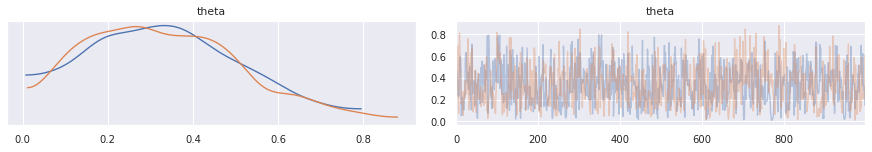

In [121]:
with our_first_model:
    az.plot_trace(trace)
    res = az.summary(trace)

In [33]:
res

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.333,0.176,0.02,0.635,0.006,0.004,851.0,851.0,817.0,834.0,1.0


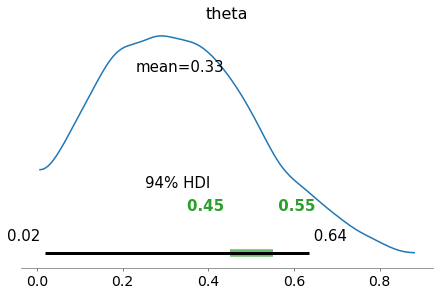

In [36]:
with our_first_model:
    az.plot_posterior(trace, rope=[0.45,0.55])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:01<00:00, 1806.53draws/s]
/home/carl/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f12322820>,
      dtype=object)

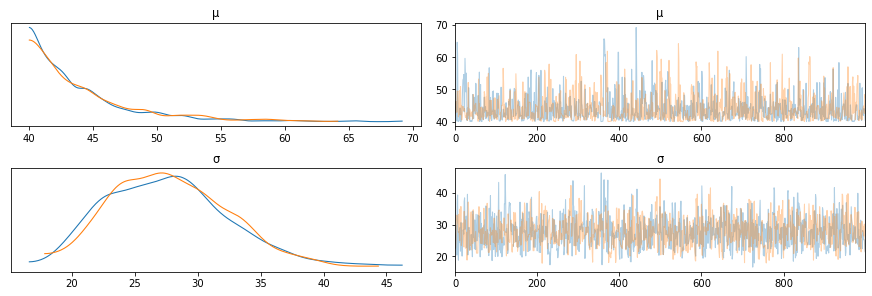

In [38]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)

/home/carl/miniconda3/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


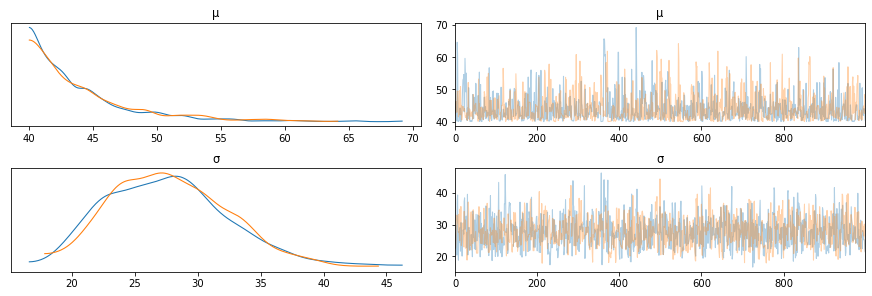

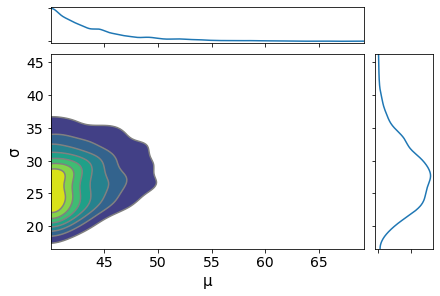

In [40]:
with model_g:
    az.plot_trace(trace_g)
    az.plot_joint(trace_g, kind='kde', fill_last=False)
plt.show()

In [42]:
trace_g['σ']

array([22.28792568, 26.64281735, 26.04688299, ..., 30.11668141,
       28.97145165, 21.55746387])

# Group comparison

In [55]:
import pandas as pd
import seaborn as sns
sns.set()

In [45]:
tips = pd.read_csv('data/tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


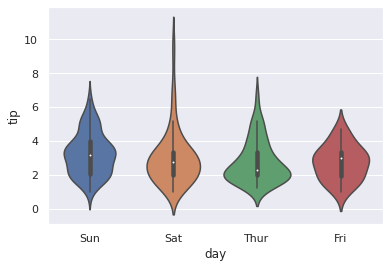

In [57]:
sns.violinplot(x='day', y='tip', data=tips)

In [61]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))
groups

4

In [63]:
with pm.Model() as comparison_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)
    trace_cg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:07<00:00, 1399.72draws/s]


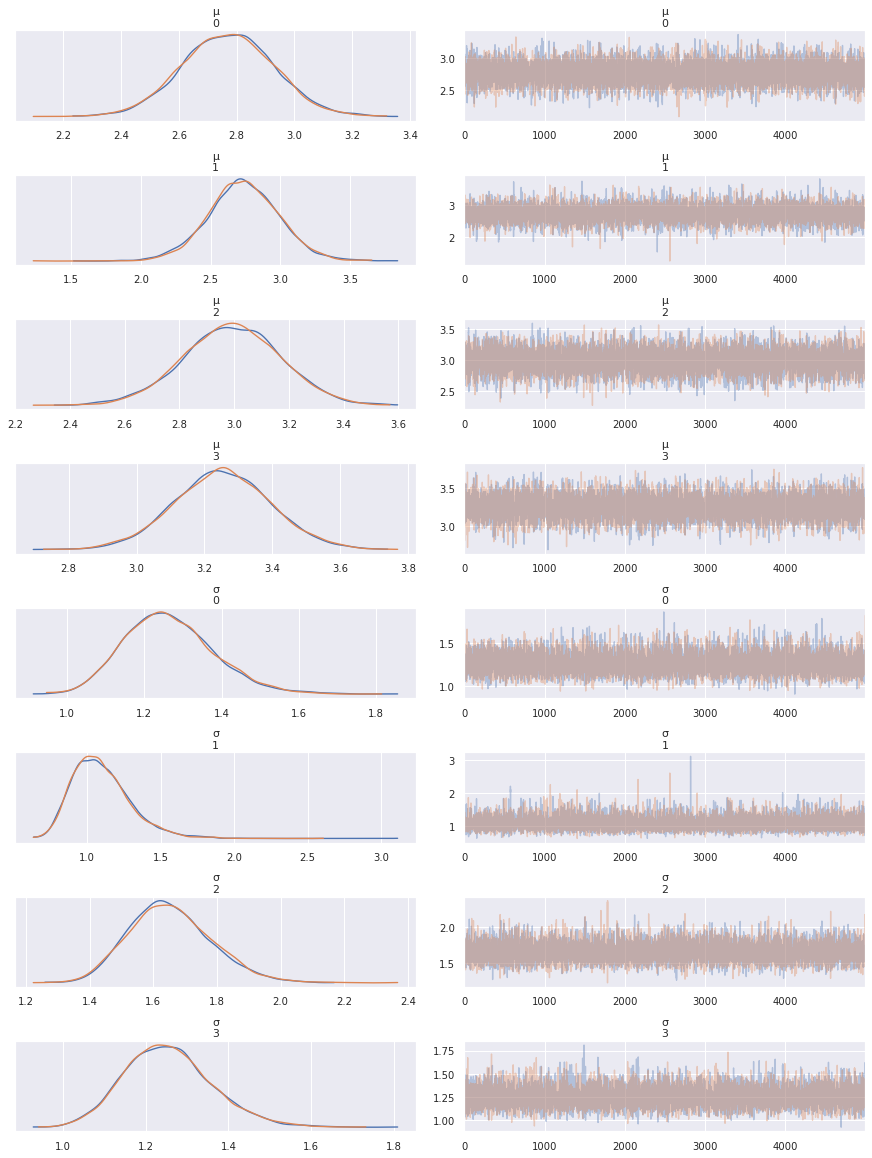

In [64]:
with comparison_groups:
    az.plot_trace(trace_cg)

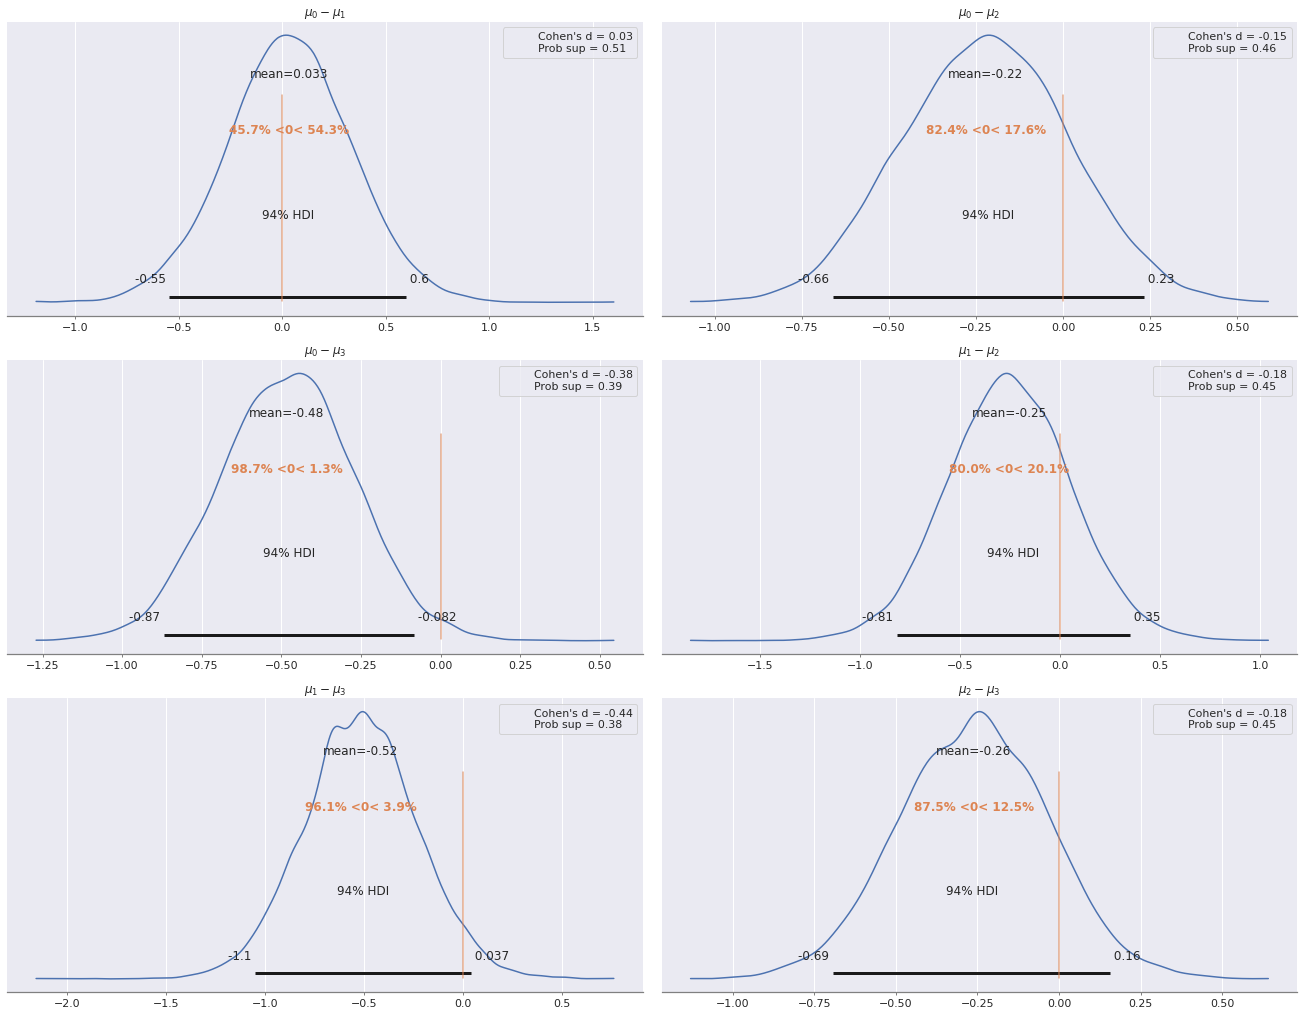

In [72]:
dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(18,14), constrained_layout=True)
comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l) for k in range(3) for l in (0,1)]
for (i, j), (k,l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2)/2)).mean()
    ps = dist.cdf(d_cohen/np.sqrt(2))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}",alpha=0)
    ax[k, l].legend()

# Hierarchical models

E.g with retailers  
__Hierarchical model/Multilevel model__: An example would be if we create a model for each retailer and one for all retailers at the same time.

We add hyperparameters to impact our priors

## Example 1

In [90]:
N_samples = [30, 30, 30]
G_samples = [3, 3, 15]
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-
    G_samples[i]]))

In [91]:
set(group_idx), set(data)

({0, 1, 2}, {0, 1})

Here $\kappa$ controls the concentration of the Beta distribution and is analog to the inverse of the standard deviation.

In [92]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)
    θ = pm.Beta('θ', alpha=μ*κ, beta=(1-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
    trace_h = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, κ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:04<00:00, 1042.26draws/s]


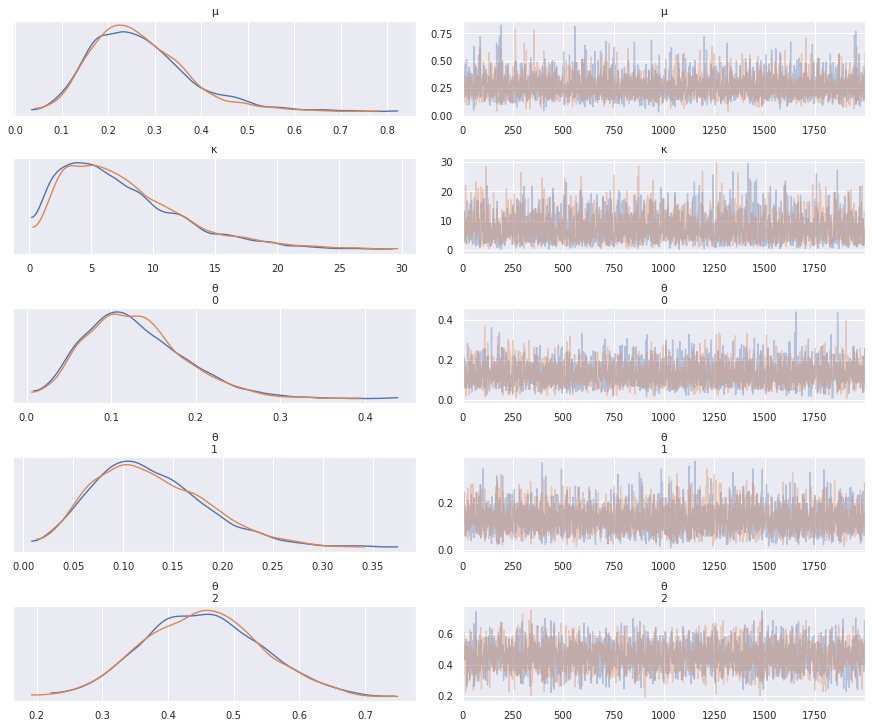

In [93]:
with model_h:
    az.plot_trace(trace_h)

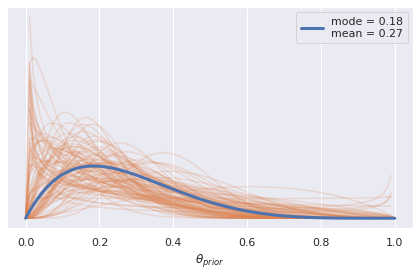

In [95]:
## How does the estimated prior look like?

x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['μ'][i]
    k = trace_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf, 'C1', alpha=0.2)

u_mean = trace_h['μ'].mean()
k_mean = trace_h['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)

pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])
plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()

## Example 2
Chemical shifts
Building two models to inspect if theoretical results can be reproduced by experiments.

In [103]:
cs_data = pd.read_csv('data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

In [104]:
cs_data.sample(2)

,ID,aa,theo,exp
1700,1KS9,ALA,54.39,54.66
1303,1IWM,TRP,62.61,57.02


In [106]:
## One model for each group
with pm.Model() as cs_nh:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)
    trace_cs_nh = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 617.72draws/s]


In [107]:
## Hierarchical version
with pm.Model() as cs_h:
    # Hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)
    # Priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ  = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)
    trace_cs_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ, σ_μ, μ_μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 646.05draws/s]


/home/carl/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


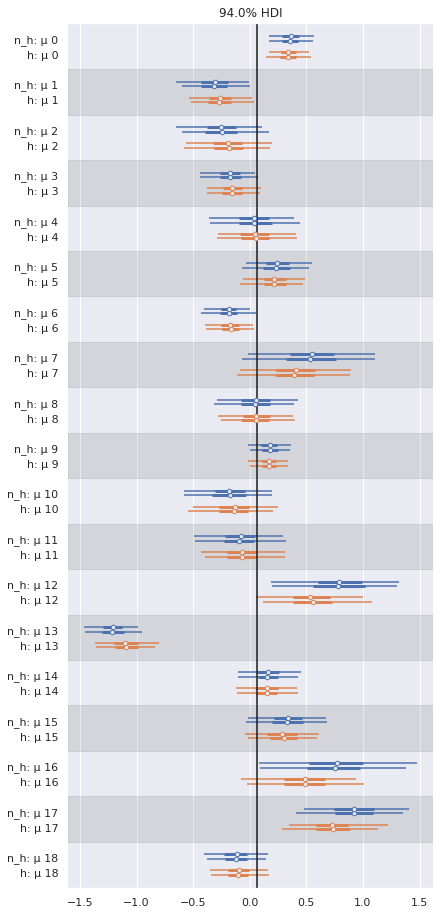

In [109]:
axes = az.plot_forest([trace_cs_nh, trace_cs_h],
model_names=['n_h', 'h'],
var_names='μ', combined=False, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_μ'].mean(), *y_lims)

## Lessons from the 2 examples
Without any hyper priors the group models are completely independent. Nothing is constraining them. With Hierarchical models we add shrinkage and pull them to the "weighted" mean.

## Exercises of Ch 2

2.

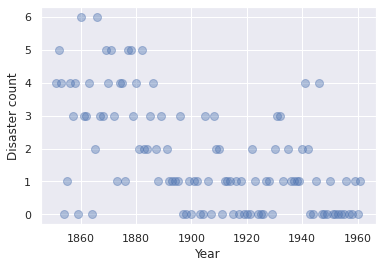

In [122]:
import pandas as pd

# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");


In [149]:
with pm.Model() as disaster_model:
    ## Testval is the first value that will be testing. Default is mean
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max(), testval=1900)
    
    ## Add priors
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)
    
    ## Poisson rates for before and after
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)
    disasters = pm.Poisson("disaster", rate, observed=disaster_data)
    
    trace = pm.sample(10000)

/home/carl/miniconda3/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in disaster contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disaster_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:15<00:00, 1382.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


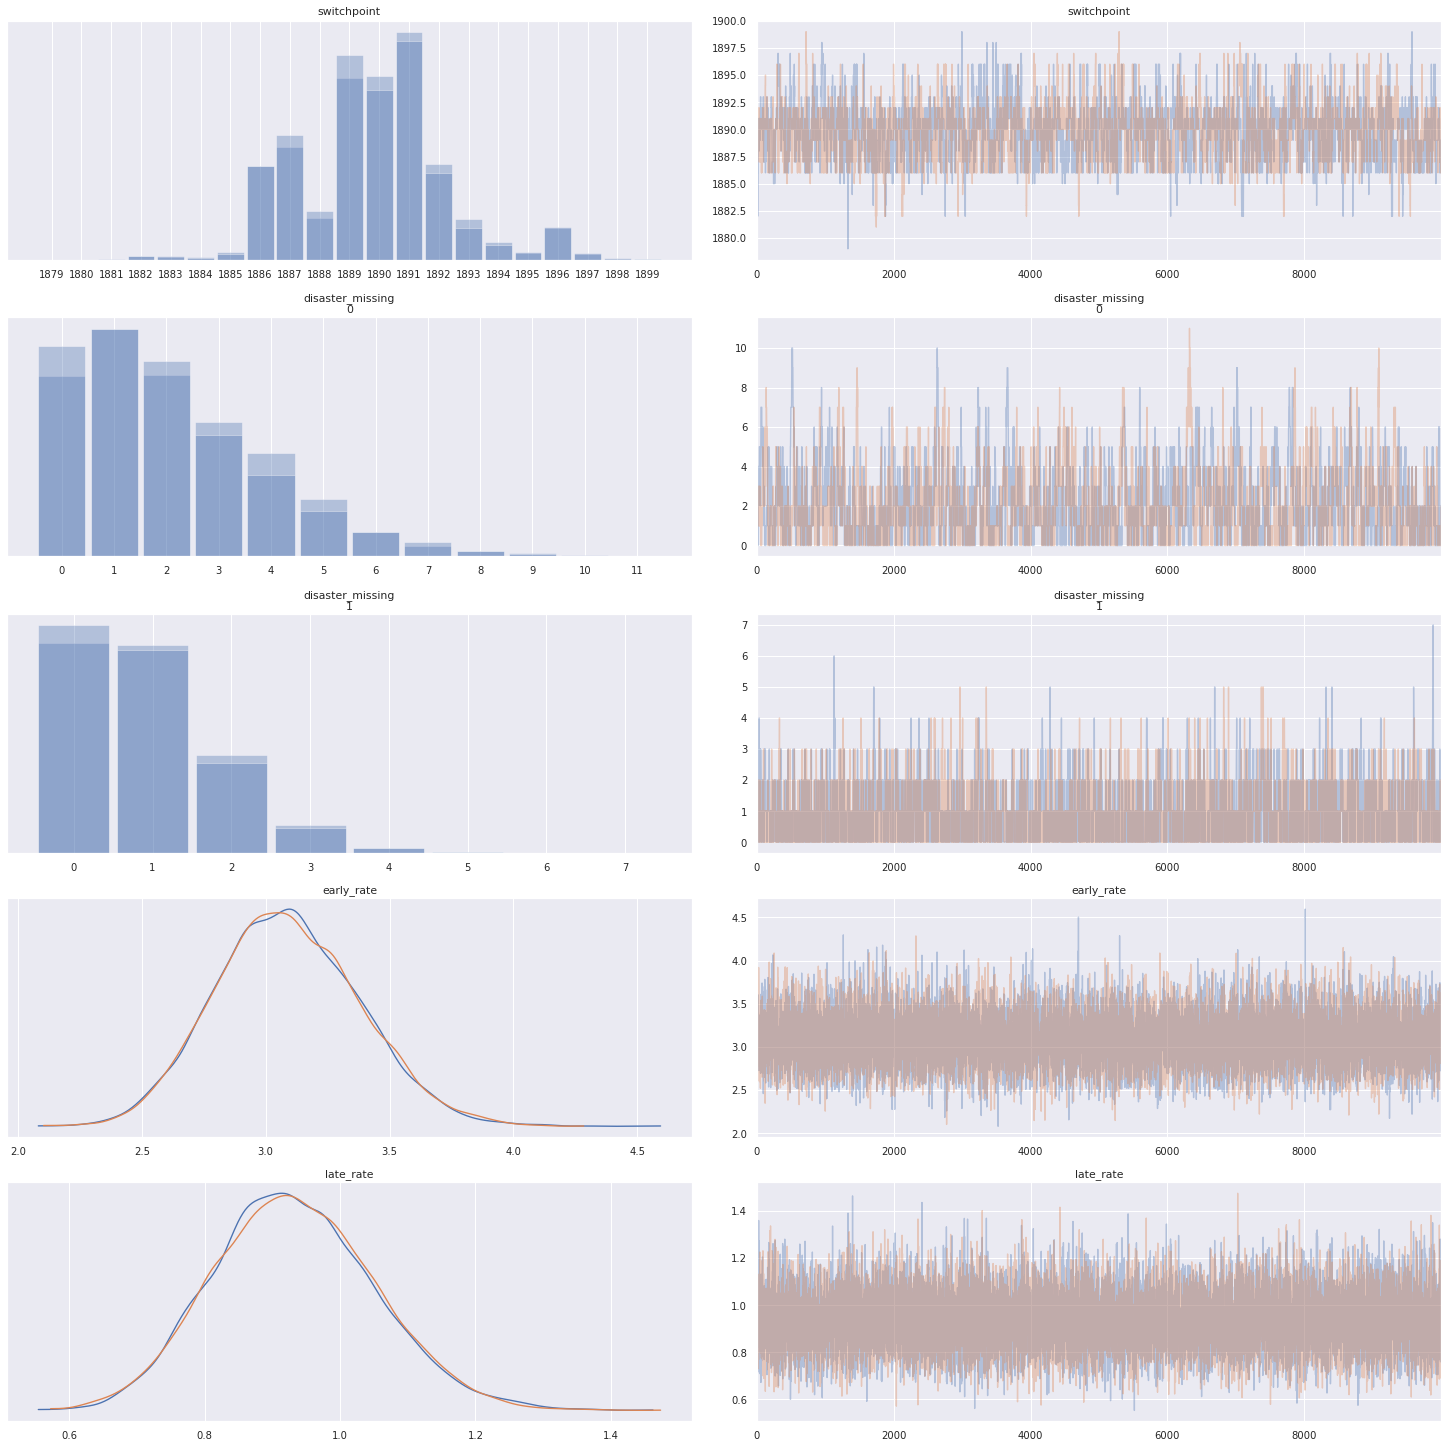

In [154]:
with disaster_model:
    az.plot_trace(trace, figsize=(20,20))

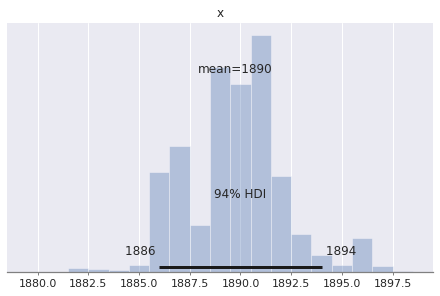

In [160]:
az.plot_posterior(trace["switchpoint"])

In [163]:
sp_hpd = az.hdi(trace["switchpoint"])
sp_hpd

array([1886, 1894])

### My own example with retailers. Let's make three models. A general, one per group and one hierarchical

In [165]:
len(retailer_1)

13

In [178]:
retailer_1 = [7, 10, 11, 17, 12, 15, 9, 11, 14, 10, 12, 8, 9]
retailer_poisson = list(stats.poisson.rvs(12, size=len(retailer_1)))
retailer_massive_tail = [7, 7, 8, 8, 10, 10, 12, 12, 16, 18, 20, 22]
groups = [0] * len(retailer_1) + [1] * len(retailer_poisson) + [2] * len(retailer_massive_tail)
df = pd.DataFrame({'group': groups, 'sold': retailer_1 + retailer_poisson + retailer_massive_tail})

In [177]:
df.sample(5)

,group,retailers
0,0,7
24,1,11
34,2,16
3,0,17
15,1,16


#### Model 1

In [221]:
## Let's build three models... One for all and one for each retailer
with pm.Model() as retailer_baseline:
#     υ = pm.Exponential('υ', 1/30)
    μ = pm.Uniform("μ", lower=df['sold'].min(), upper=df['sold'].max())
#     σ = pm.HalfNormal('σ', sd=10)
#     y = pm.Normal("y", mu=μ, sd=σ, nu=υ, observed=df['sold'])
    y = pm.Poisson("y", mu=μ, observed=df['sold'].values)
    trace_baseline = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:02<00:00, 2653.29draws/s]


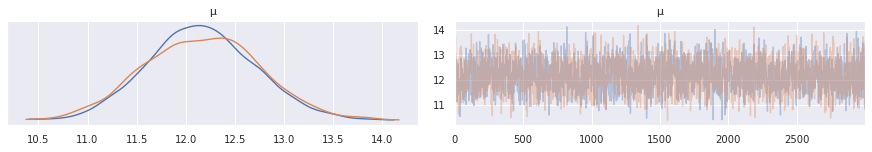

In [222]:
with retailer_baseline:
    az.plot_trace(trace_baseline)

In [223]:
with retailer_baseline:
    summary = az.summary(trace_baseline)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,12.162,0.571,11.134,13.275,0.011,0.008,2820.0,2820.0,2830.0,4178.0,1.0


In [224]:
with retailer_baseline:
    ppc_baseline = pm.sample_posterior_predictive(trace_baseline, 100, retailer_baseline)
    

/home/carl/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 1699.72it/s]


In [225]:
with retailer_baseline:
    y_pred_t = az.from_pymc3(trace=trace_baseline, posterior_predictive=ppc_baseline)

arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


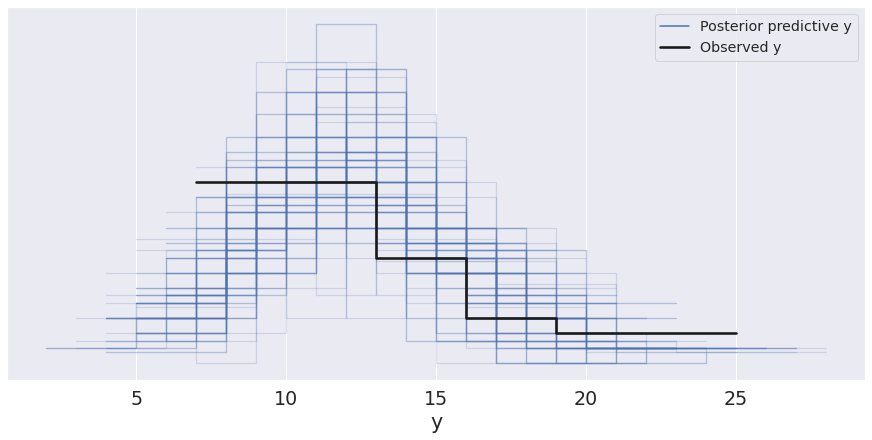

In [226]:
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)

#### Model 2

In [229]:
with pm.Model() as retailer_multi:
    theta = pm.Dirichlet("theta", a=np.ones(len(df)))
    post = pm.Multinomial("post", n=df['sold'].sum(), p=theta, observed=df['sold'])
#     y = pm.Poisson("y", mu=μ, observed=df['sold'].values)
    trace_multi = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:07<00:00, 993.05draws/s] 


In [231]:
az.summary(trace_multi)

/home/carl/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],0.016,0.006,0.007,0.027,0.0,0.0,13198.0,8908.0,13956.0,3877.0,1.0
theta[1],0.022,0.007,0.011,0.035,0.0,0.0,14975.0,10436.0,14693.0,4271.0,1.0
theta[2],0.024,0.007,0.012,0.038,0.0,0.0,14181.0,10685.0,14252.0,4259.0,1.0
theta[3],0.036,0.008,0.021,0.051,0.0,0.0,12556.0,10585.0,12437.0,3527.0,1.0
theta[4],0.026,0.007,0.013,0.039,0.0,0.0,12332.0,10675.0,11930.0,4152.0,1.0
theta[5],0.032,0.008,0.018,0.047,0.0,0.0,11646.0,9670.0,11429.0,3873.0,1.0
theta[6],0.020,0.006,0.009,0.031,0.0,0.0,10991.0,8911.0,10781.0,4076.0,1.0
theta[7],0.024,0.007,0.012,0.037,0.0,0.0,13476.0,10209.0,13882.0,4349.0,1.0
theta[8],0.030,0.008,0.016,0.044,0.0,0.0,11908.0,9605.0,12337.0,4266.0,1.0
theta[9],0.022,0.007,0.011,0.035,0.0,0.0,11314.0,8950.0,11288.0,4148.0,1.0


100%|██████████| 100/100 [00:00<00:00, 594.62it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable post's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


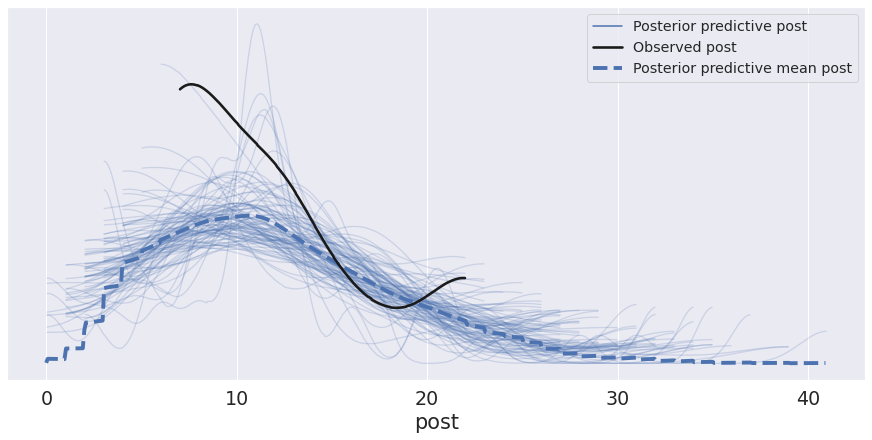

In [233]:
with retailer_multi:
    y_ppc_t = pm.sample_posterior_predictive(trace_multi, 100, retailer_multi, random_seed=123)
    y_pred_t = az.from_pymc3(trace=trace_multi, posterior_predictive=y_ppc_t)
    az.plot_ppc(y_pred_t, figsize=(12, 6), )

# One per group

In [246]:
with pm.Model() as model_g:
    μ = pm.Uniform("μ", lower=df['sold'].min(), upper=df['sold'].max(), shape=3)
    y = pm.Poisson("y", mu=μ[df['group']], observed=df['sold'].values)
    trace_g= pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:04<00:00, 1723.79draws/s]


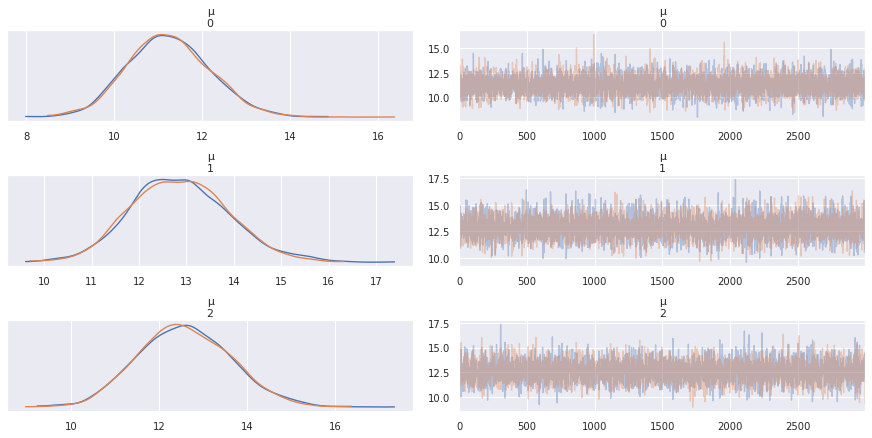

In [247]:
with model_g:
    az.plot_trace(trace_g)

In [249]:
with model_g:
    summary = az.summary(trace_g)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],11.246,0.949,9.535,13.021,0.011,0.008,7286.0,7160.0,7406.0,4300.0,1.0
μ[1],12.860,1.026,10.885,14.715,0.012,0.008,7545.0,7460.0,7567.0,4265.0,1.0
μ[2],12.580,1.056,10.638,14.522,0.012,0.009,7700.0,7610.0,7698.0,4793.0,1.0


/home/carl/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 648.24it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


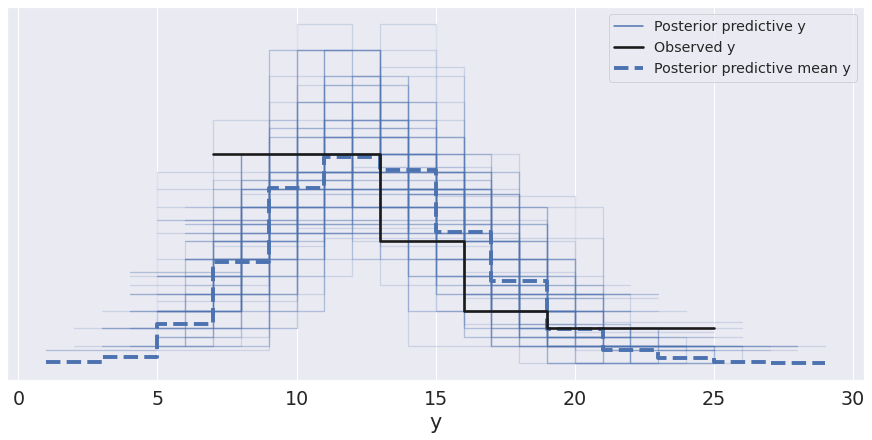

In [248]:
with model_g:
    y_ppc_t = pm.sample_posterior_predictive(trace_g, 100, model_g, random_seed=123)
    y_pred_t = az.from_pymc3(trace=trace_g, posterior_predictive=y_ppc_t)
    az.plot_ppc(y_pred_t, figsize=(12, 6), )